In [1]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from typing import Iterator, List, Callable, Tuple
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
from google.colab import drive
import numpy as np

In [2]:
train_data_url = 'https://drive.google.com/file/d/1M2sfCHmA0vACe4YFCN-RuN5vbrv3_Kdk/view?usp=sharing'
train_data_csv = pd.read_csv('https://drive.google.com/uc?export=download&id='+train_data_url.split('/')[-2])

test_data_url = 'https://drive.google.com/file/d/1MHmdyBg1RWPm3HvB8ydh5lxMcnndvDH9/view?usp=sharing'
test_data_csv = pd.read_csv('https://drive.google.com/uc?export=download&id='+test_data_url.split('/')[-2])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
train_data_csv

,Text,Final Labels,Id
0,@CorinaTomescu05 Încă nu ...dar am trecut prin...,non-offensive,0
1,@emosaphicbitch sau rosu ca mine,non-offensive,1
2,@DanaMinodora Ce frumoasa ești.. Arăți foarte ...,non-offensive,2
3,Din fericire în extaz!Ai dus covoareleeee?? Pu...,offensive,3
4,cand aveam vreo 5 ani credeam ca romana e sing...,non-offensive,4
...,...,...,...
39003,"@violetAndro @CorinaCg3 Așa e, știu atâtea exe...",non-offensive,39003
39004,"Directorul medical SAJ Galați, despre dispecer...",non-offensive,39004
39005,"Au ""invatat"" prostii de balta de la Satan ce e...",non-offensive,39005
39006,@_seriosul_ E o parte de adevar. Dar pana la u...,non-offensive,39006


Drop corrupted rows.

In [4]:
print( train_data_csv.shape)
bad_input = []
for index,row in train_data_csv.iterrows():
  if 'keyword' in row['Text']:
    bad_input.append(index)

bad_input.reverse()
print( bad_input )

for index in bad_input:
  train_data_csv = train_data_csv.drop( index )

train_data_csv.index = range(len(train_data_csv))
print( train_data_csv.shape )
#print( train_data_csv['Final labels'].shape)

(39008, 3)
[34257, 33414, 32609, 31671, 29515, 27676, 27463, 26907, 15495, 15154, 10025, 2473]
(38996, 3)


In [ ]:
! pip install emoji

Data preprocessing

In [5]:
#extract strings from dataframe
texts = []
for text in  train_data_csv["Text"]:
  texts.append(text)

tests = []
for test in test_data_csv['Text']:
  tests.append(test)

texts = [text.lower() for text in texts]
tests = [test.lower() for test in tests]

import re

#remove tags
texts_no_tags = [re.sub(r'@[a-zA-Z0-9_]+','', text) for text in texts]
tests_no_tags = [re.sub(r'@[a-zA-Z0-9_]+','', test) for test in tests]

import string

#remove punctuation
translator = str.maketrans(string.punctuation + "’–“”…„—：︵‿", ' '*len(string.punctuation + "’–“”…„—：︵‿"))
texts_no_punct = [text.translate(translator) for text in texts_no_tags]
tests_no_punct = [test.translate(translator) for test in tests_no_tags]

#remove extra spaces
texts_no_spaces = [re.sub(r'\s+', ' ', text).strip() for text in texts_no_punct]
tests_no_spaces = [re.sub(r'\s+', ' ', test).strip() for test in tests_no_punct]

import emoji

#remove emojis
text_no_emoji = [emoji.demojize(text, language='en') for text in texts_no_spaces]
test_no_emoji = [emoji.demojize(test, language='en') for test in tests_no_spaces]


In [ ]:
!python -m spacy download ro_core_news_lg

Remove stop words

In [6]:
import spacy
nlp = spacy.load('ro_core_news_lg')
stop_words_spacy = nlp.Defaults.stop_words


texts_no_stop = []
for text in text_no_emoji:
  no_stop = [word for word in text.split(' ') if word not in stop_words_spacy]
  texts_no_stop.append(" ".join(no_stop))

tests_no_stop = []
for test in test_no_emoji:
  no_stop = [word for word in test.split(' ') if word not in stop_words_spacy]
  tests_no_stop.append(" ".join(no_stop))


Words are lemmatized.

In [7]:
texts_lemma = []
for text in texts_no_stop:
  words = []
  doc = nlp(text)
  for word in doc:
    words.append(word.lemma_)
  texts_lemma.append(words)

tests_lemma = []
for test in tests_no_stop:
  words = []
  doc = nlp(test)
  for word in doc:
    words.append(word.lemma_)
  tests_lemma.append(words)

print(texts_lemma[:10])

print( type(texts_lemma), len(texts_lemma) )

[['încă', 'trece', '28', ':', 'grinning_face_with_big_eyes::grinning_face_with_big_eyes', ':', 'fericit', ':', 'thumbs_up::hibiscus', ':'], ['rosu'], ['frumoas', 'arate', 'frumoaso'], ['fericire', 'extaz', 'duce', 'covoareleeee', 'pune', 'mîna', 'aspira', 'tavan', 'perete', 'sta', 'aspirator', 'degeaba', 'bate', 'joc', 'ban', 'vaiiii', 'fura', 'răpire', 'serai', 'dreaq', 'rembranzi', 'monezi', 'dispărea', 'păgubi', 'pwp'], ['avea', '5', 'an', 'crede', 'romană', 'singur', 'limbă', 'lume', 'exista', 'injuratură', 'dată', 'auzeam', 'injurand', 'complet', 'dezgustat'], ['prințesă', 'frumos', 'sexxxxyyy'], ['ionică', 'clipă', 'vedea', 'oară', 'ști', 'vrea', 'băiat', 'vis', 'băiețel', 'penis', 'cuceri', 'inimă', 'pământ', 'iubire', 'etern', 'vrea', 'ști', 'alat', ':', 'no_one_under_eighteen::smiling_face_with_hearts::smiling_face_with_open_hands', ':'], ['coronavirus', 'România', '29', 'iunie', '2021', '294', 'deces', 'înregistra', 'ultim', '24', 'oră'], ['ieși', 'casă'], ['corp', 'mod', 'to

In [8]:
train_data = texts_lemma
for index,text in enumerate(train_data):
  row = ' '.join(str(word) for word in text)
  train_data_csv.loc[index, 'Text'] = row

test_data = tests_lemma
for index,test in enumerate(test_data):
  row = ' '.join(str(word) for word in test)
  test_data_csv.loc[index, 'Text'] = row

train_data_csv[:10]

,Text,Final Labels,Id
0,încă trece 28 : grinning_face_with_big_eyes::g...,non-offensive,0
1,rosu,non-offensive,1
2,frumoas arate frumoaso,non-offensive,2
3,fericire extaz duce covoareleeee pune mîna asp...,offensive,3
4,avea 5 an crede romană singur limbă lume exist...,non-offensive,4
5,prințesă frumos sexxxxyyy,direct,5
6,ionică clipă vedea oară ști vrea băiat vis băi...,direct,6
7,coronavirus România 29 iunie 2021 294 deces în...,non-offensive,7
8,ieși casă,offensive,8
9,corp mod toamnă somn devreme chef bandă,non-offensive,9


In [9]:
from google.colab import  drive
drive.mount('/drive')
train_data_csv.to_csv('/drive/My Drive/Nitro NLP - cercopitechs/preprocessed_train.csv')
test_data_csv.to_csv('/drive/My Drive/Nitro NLP - cercopitechs/preprocessed_test.csv')




Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
train_data_csv = pd.read_csv("/drive/My Drive/Nitro NLP - cercopitechs/preprocessed_train.csv")
train_data_csv = train_data_csv.astype(str)

test_data_csv = pd.read_csv("/drive/My Drive/Nitro NLP - cercopitechs/preprocessed_test.csv")
test_data_csv = test_data_csv.astype(str)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Embedding, BatchNormalization, Dense, Flatten, Dropout, Bidirectional,Flatten, GlobalMaxPool1D,Dropout
from keras.callbacks import EarlyStopping
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn import svm
import math

labels = {'non-offensive':0,
          'offensive':1,
          'direct':2,
          'descriptive':3,
          'reporting':4
          }

train_data = train_data_csv['Text']
test_data = test_data_csv['Text']

train_data_csv['Final Labels'] = train_data_csv['Final Labels'].map(lambda x: labels[x])
train_labels = train_data_csv['Final Labels']

#for SVM
off,not_off,direct,desc,rep = np.bincount(train_data_csv['Final Labels'])
num_labels = len(train_data_csv['Final Labels'])

del train_data_csv


In [12]:
train_data

0        încă trece 28 : grinning_face_with_big_eyes::g...
1                                                     rosu
2                                   frumoas arate frumoaso
3        fericire extaz duce covoareleeee pune mîna asp...
4        avea 5 an crede romană singur limbă lume exist...
                               ...                        
38991                    așa atât exemplu strica copil bai
38992    director medical saj galat dispeceră 112 atitu...
38993                    invata prostie baltă satan om bun
38994    parte adevar pană urmă posibilitate medalie jo...
38995    răbdare vedea spune Olanda putea bulgar întâi ...
Name: Text, Length: 38996, dtype: object

Epoch 1/20
195/195 [==============================] - 6s 18ms/step - loss: 0.8222 - accuracy: 0.7827 - val_loss: 0.6340 - val_accuracy: 0.7929
Epoch 2/20
195/195 [==============================] - 2s 12ms/step - loss: 0.5865 - accuracy: 0.8121 - val_loss: 0.5484 - val_accuracy: 0.8272
Epoch 2: early stopping
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


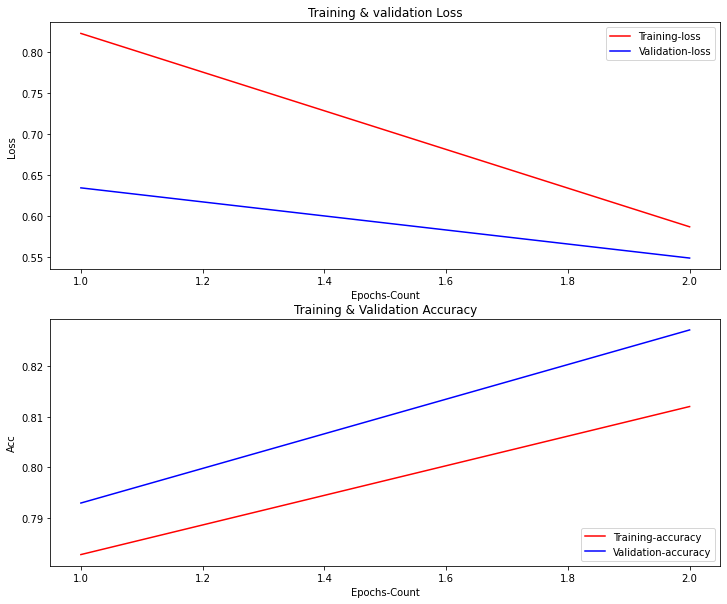

In [8]:
tfidf = TfidfVectorizer(binary=True, max_features = 20000, dtype = np.float32)

#for mlp - RAM crash with float16 :(
train_data = tfidf.fit_transform(train_data).todense()
train_labels = np_utils.to_categorical(train_labels)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)

def MLP():
  model = Sequential()
  model.add(Dense(512, activation='relu')) #dense_layer
  model.add(Dropout(0.9))#dropout_layer
  model.add(Dense(5, activation="softmax", name='classifier')) #classification_layer
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  return model

#building model
mlp_model=MLP()

#running model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mlp_history = mlp_model.fit(train_data, 
                      train_labels, 
                      batch_size=128,
                      epochs=20,
                      validation_data=(val_data, val_labels),
                      callbacks = [es])

history_dict = mlp_history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

#defining_figures
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()
#1st_figure
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training-loss')#training_loss
plt.plot(epochs, val_loss, 'b', label='Validation-loss')#validation_loss
plt.title('Training & validation Loss')
plt.xlabel('Epochs-Count')
plt.ylabel('Loss')
plt.legend()
#2nd_Figure
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training-accuracy')#training_accuracy
plt.plot(epochs, val_acc, 'b', label='Validation-accuracy')#validation_accuracy
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs-Count')
plt.ylabel('Acc')
plt.legend(loc='lower right')

#y_test = np.array(list(chain.from_iterable(y_test)))
#predicting
#y_pred = build_model.predict_classes(x_test, verbose=0)

#creating reports
#print(confusion_matrix(y_test_, y_pred))
#print(classification_report(y_test_, y_pred))

In [4]:
def UnmapLabels( label ):
  unmap_labels = {0 : 'non-offensive',
          1 : 'offensive',
          2 : 'direct',
          3 : 'descriptive',
          4 : 'reporting'
          }
  return unmap_labels[label]

In [5]:
run_on_test = False

Tfidf_vect = TfidfVectorizer()

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)

Tfidf_vect.fit(train_data)

Train_data_Tfidf = Tfidf_vect.transform(train_data)
Val_data_Tfidf = Tfidf_vect.transform(val_data)
Test_data_Tfidf = Tfidf_vect.transform(test_data)

In [6]:
print( off, not_off, direct, desc, rep)

weight_off = (num_labels / off)/5.0 
weight_not_off = (num_labels / not_off)/5.0
weight_direct = (num_labels / direct)/5.0
weight_desc = (num_labels / desc)/5.0
weight_rep = (num_labels / rep)/5.0
class_weight = {0: weight_off, 1: weight_not_off, 2: weight_direct, 3: weight_desc, 4: weight_rep}

print(class_weight)
#running SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',verbose=True,class_weight=class_weight)
SVM.fit(Train_data_Tfidf,train_labels)

#predciting
if run_on_test is False:
  predictions_SVM = SVM.predict(Val_data_Tfidf)
  print(classification_report(val_labels,predictions_SVM))
else:
  predictions_SVM = SVM.predict(Test_data_Tfidf)
  drive.mount('/drive')
  predictions_SVM = [[idx,UnmapLabels(label)] for idx,label in enumerate(predictions_SVM)]
  predictions_SVM = pd.DataFrame( predictions_SVM, columns = ['Id', 'Label'])
  predictions_SVM.set_index( 'Id', inplace=True )
  predictions_SVM.to_csv('/drive/My Drive/Nitro NLP - cercopitechs/SVM_predictions.csv')


30828 4299 2156 1494 219
{0: 0.2529907875956922, 1: 1.8141893463596186, 2: 3.617439703153989, 3: 5.220348058902276, 4: 35.612785388127854}
[LibSVM]              precision    recall  f1-score   support

           0       0.93      0.86      0.89      6215
           1       0.53      0.60      0.56       868
           2       0.51      0.72      0.60       408
           3       0.37      0.61      0.46       268
           4       0.36      0.12      0.18        41

    accuracy                           0.81      7800
   macro avg       0.54      0.58      0.54      7800
weighted avg       0.84      0.81      0.82      7800



In [7]:
#running XGB
xgb_classifier = xgb.XGBClassifier()
xgb= xgb_classifier.fit(Train_data_Tfidf,train_labels)

#predciting
if run_on_test is False:
  predictions_xgb = xgb.predict(Val_data_Tfidf)
  print(classification_report(val_labels,predictions_xgb))
else:
  predictions_xgb = xgb.predict(Test_data_Tfidf)
  drive.mount('/drive')
  predictions_xgb = [[idx,UnmapLabels(label)] for idx,label in enumerate(predictions_xgb)]
  predictions_xgb = pd.DataFrame( predictions_xgb, columns = ['Id', 'Label'])
  predictions_xgb.set_index( 'Id', inplace=True )
  predictions_xgb.to_csv('/drive/My Drive/Nitro NLP - cercopitechs/XGB_predictions.csv')

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6215
           1       0.70      0.41      0.52       868
           2       0.84      0.48      0.61       408
           3       0.46      0.26      0.34       268
           4       1.00      0.07      0.14        41

    accuracy                           0.85      7800
   macro avg       0.77      0.44      0.50      7800
weighted avg       0.84      0.85      0.83      7800



In [ ]:
 predictions_xgb